In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('use_inf_as_na', True)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
liq_data = pd.read_csv('bid_ask.csv')

In [5]:
liq_data.head()

,Unnamed: 0,Date,EXCHCD,TICKER,COMNAM,BIDLO,ASKHI,PRC,VOL,RET,SHROUT,OPENPRC,vwretx
0,1031570,2019-01-02,3.0,INTC,INTEL CORP,45.77,47.470,47.08,18761673.0,0.003196,4564000.0,45.960,0.001783
1,1031571,2019-01-03,3.0,INTC,INTEL CORP,44.39,46.280,44.49,32254097.0,-0.055013,4564000.0,46.150,-0.021219
2,1031572,2019-01-04,3.0,INTC,INTEL CORP,45.54,47.570,47.22,35419836.0,0.061362,4564000.0,45.835,0.033399
3,1031573,2019-01-07,3.0,INTC,INTEL CORP,46.75,47.995,47.44,22724997.0,0.004659,4564000.0,47.100,0.009191
4,1031574,2019-01-08,3.0,INTC,INTEL CORP,46.78,48.030,47.74,22721240.0,0.006324,4564000.0,47.800,0.010240


In [6]:
rolling_five = []

for j in liq_data.TICKER.unique():
    for i in range(len(liq_data[liq_data.TICKER == j])):
        rolling_five.append(liq_data[i:i+5].agg({'BIDLO': 'min',
                                                'ASKHI': 'max',
                                                 'VOL': 'sum',
                                                 'SHROUT': 'mean',
                                                 'PRC': 'mean'}))

In [7]:
rolling_five_df = pd.DataFrame(rolling_five)
rolling_five_df.columns = ['bidlo_min', 'askhi_max', 'vol_sum',
                           'shrout_mean', 'prc_mean']
liq_vol_all = pd.concat([liq_data,rolling_five_df], axis=1)

## Volume Based Measure

In [8]:
liq_ratio = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        liq_ratio.append((liq_vol_all['PRC'][i+1:i+6] * 
                          liq_vol_all['VOL'][i+1:i+6]).sum()/
                         (np.abs(liq_vol_all['PRC'][i+1:i+6].mean() - 
                                 liq_vol_all['PRC'][i:i+5].mean())))

In [9]:
Lhh = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        Lhh.append((liq_vol_all['PRC'][i:i+5].max() - 
                    liq_vol_all['PRC'][i:i+5].min()) /  
                   liq_vol_all['PRC'][i:i+5].min() /  
                   (liq_vol_all['VOL'][i:i+5].sum() / 
                    liq_vol_all['SHROUT'][i:i+5].mean() * 
                    liq_vol_all['PRC'][i:i+5].mean()))

In [10]:
turnover_ratio = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        turnover_ratio.append((1/liq_vol_all['VOL'].count()) * 
                              (np.sum(liq_vol_all['VOL'][i:i+1]) / 
                               np.sum(liq_vol_all['SHROUT'][i:i+1])))

In [11]:
liq_vol_all['liq_ratio'] = pd.DataFrame(liq_ratio)
liq_vol_all['Lhh'] = pd.DataFrame(Lhh)
liq_vol_all['turnover_ratio'] = pd.DataFrame(turnover_ratio)

## Transaction Cost Based Measures

### Bid-Ask Spreads

In [12]:
liq_vol_all['mid_price'] = (liq_vol_all.ASKHI + liq_vol_all.BIDLO) / 2
liq_vol_all['percent_quoted_ba'] = (liq_vol_all.ASKHI - 
                                    liq_vol_all.BIDLO) / \
                                    liq_vol_all.mid_price
liq_vol_all['percent_effective_ba'] = 2 * abs((liq_vol_all.PRC - 
                                               liq_vol_all.mid_price)) / \
                                               liq_vol_all.mid_price

### Roll's Spread

In [13]:
liq_vol_all['price_diff'] = liq_vol_all.groupby('TICKER')['PRC']\
                            .apply(lambda x:x.diff())
liq_vol_all.dropna(inplace=True)
roll = []

for j in liq_vol_all.TICKER.unique():
     for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        roll_cov = np.cov(liq_vol_all['price_diff'][i:i+5], 
                          liq_vol_all['price_diff'][i+1:i+6])
        if roll_cov[0,1] < 0:
            roll.append(2 * np.sqrt(-roll_cov[0, 1]))
        else:
             roll.append(2 * np.sqrt(np.abs(roll_cov[0, 1])))


### Corwin and Schultz (2012)

In [14]:
gamma = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        gamma.append((max(liq_vol_all['ASKHI'].iloc[i+1], 
                          liq_vol_all['ASKHI'].iloc[i]) - 
                      min(liq_vol_all['BIDLO'].iloc[i+1], 
                          liq_vol_all['BIDLO'].iloc[i])) ** 2)
        gamma_array = np.array(gamma)

In [15]:
beta = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        beta.append((liq_vol_all['ASKHI'].iloc[i+1] - 
                     liq_vol_all['BIDLO'].iloc[i+1]) ** 2 + 
                    (liq_vol_all['ASKHI'].iloc[i] - 
                     liq_vol_all['BIDLO'].iloc[i]) ** 2)
        beta_array = np.array(beta)

In [16]:
alpha = ((np.sqrt(2 * beta_array) - np.sqrt(beta_array)) / 
       (3 - (2 * np.sqrt(2)))) - np.sqrt(gamma_array / 
                                         (3 - (2 * np.sqrt(2))))
CS_spread = (2 * np.exp(alpha - 1)) / (1 + np.exp(alpha))

In [17]:
liq_vol_all = liq_vol_all.reset_index()
liq_vol_all['roll'] = pd.DataFrame(roll)
liq_vol_all['CS_spread'] = pd.DataFrame(CS_spread)

## Price Based Measures

In [18]:
dvol = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        dvol.append((liq_vol_all['PRC'][i:i+5] *
                     liq_vol_all['VOL'][i:i+5]).sum())
liq_vol_all['dvol'] = pd.DataFrame(dvol)

In [19]:
amihud = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        amihud.append((1 / liq_vol_all['RET'].count()) * 
                      (np.sum(np.abs(liq_vol_all['RET'][i:i+1])) / 
                              np.sum(liq_vol_all['dvol'][i:i+1])))

In [20]:
florackis = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        florackis.append((1 / liq_vol_all['RET'].count()) * 
                         (np.sum(np.abs(liq_vol_all['RET'][i:i+1]) / 
                                 liq_vol_all['turnover_ratio'][i:i+1])))

In [21]:
liq_vol_all['vol_diff_pct'] = liq_vol_all.groupby('TICKER')['VOL']\
                              .apply(lambda x: x.diff()).pct_change()
liq_vol_all['price_diff_pct'] = liq_vol_all.groupby('TICKER')['PRC']\
                              .apply(lambda x: x.diff()).pct_change()

In [22]:
cet = []

for j in liq_vol_all.TICKER.unique():
    for i in range(len(liq_vol_all[liq_vol_all.TICKER == j])):
        cet.append(np.sum(liq_vol_all['vol_diff_pct'][i:i+1])/
                   np.sum(liq_vol_all['price_diff_pct'][i:i+1]))

In [23]:
liq_vol_all['amihud'] = pd.DataFrame(amihud)
liq_vol_all['florackis'] = pd.DataFrame(florackis)
liq_vol_all['cet'] = pd.DataFrame(cet)

## Market Impact Measures

In [24]:
import statsmodels.api as sm

In [25]:
liq_vol_all['VOL_pct_change'] = liq_vol_all.groupby('TICKER')['VOL']\
                                .apply(lambda x: x.pct_change())
liq_vol_all.dropna(subset=['VOL_pct_change'], inplace=True)
liq_vol_all = liq_vol_all.reset_index()

In [26]:
unsys_resid = []

for i in liq_vol_all.TICKER.unique():
    X1 = liq_vol_all[liq_vol_all['TICKER'] == i]['vwretx']
    y = liq_vol_all[liq_vol_all['TICKER'] == i]['RET']
    ols = sm.OLS(y, X1).fit()
    unsys_resid.append(ols.resid)

In [27]:
market_impact = {}

for i, j in zip(liq_vol_all.TICKER.unique(), 
                range(len(liq_vol_all['TICKER'].unique()))):
    X2 = liq_vol_all[liq_vol_all['TICKER'] == i]['VOL_pct_change']
    ols = sm.OLS(unsys_resid[j] ** 2, X2).fit()
    print('***' * 30)
    print(f'OLS Result for {i}')
    print(ols.summary())
    market_impact[j] = ols.resid

******************************************************************************************
OLS Result for INTC
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.157
Model:                            OLS   Adj. R-squared (uncentered):              0.154
Method:                 Least Squares   F-statistic:                              46.31
Date:                Sat, 07 Jan 2023   Prob (F-statistic):                    7.53e-11
Time:                        01:15:31   Log-Likelihood:                          1444.9
No. Observations:                 249   AIC:                                     -2888.
Df Residuals:                     248   BIC:                                     -2884.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
         

In [28]:
append1 = market_impact[0].append(market_impact[1])
liq_vol_all['market_impact'] = append1.append(market_impact[2])

In [29]:
cols = ['vol_diff_pct', 'price_diff_pct', 'price_diff',
        'VOL_pct_change', 'dvol', 'mid_price']
liq_measures_all = liq_vol_all.drop(liq_vol_all[cols], axis=1)\
                   .iloc[:, -11:]
liq_measures_all.dropna(inplace=True)
liq_measures_all.describe().T

,count,mean,std,min,25%,50%,75%,max
liq_ratio,738.0,7.368514e+10,2.569030e+11,8.065402e+08,1.378496e+10,2.261858e+10,4.505784e+10,3.095986e+12
Lhh,738.0,3.340167e-05,5.371681e-05,3.966368e-06,1.694354e-05,2.368095e-05,3.558960e-05,5.824148e-04
turnover_ratio,738.0,6.491127e-03,2.842668e-03,1.916371e-03,4.897990e-03,5.764112e-03,7.423111e-03,2.542853e-02
percent_quoted_ba,738.0,1.565276e-02,7.562850e-03,3.779877e-03,1.041887e-02,1.379992e-02,1.878123e-02,5.545110e-02
percent_effective_ba,738.0,8.334177e-03,7.100304e-03,0.000000e+00,3.032785e-03,6.851479e-03,1.152485e-02,4.656669e-02
roll,738.0,8.190794e-01,6.066821e-01,7.615773e-02,4.574986e-01,6.975982e-01,1.011879e+00,4.178873e+00
CS_spread,738.0,3.305464e-01,1.267434e-01,1.773438e-40,2.444225e-01,3.609800e-01,4.188028e-01,5.877726e-01
amihud,738.0,2.777021e-15,2.319450e-15,0.000000e+00,1.117729e-15,2.220439e-15,3.766086e-15,1.320828e-14
florackis,738.0,2.284291e-03,1.546181e-03,0.000000e+00,1.059446e-03,2.013517e-03,3.324181e-03,7.869841e-03
cet,738.0,-1.113583e+00,3.333932e+01,-4.575246e+02,-1.687807e-01,5.654237e-01,1.660166e+00,1.845917e+02


## GMM

In [30]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [31]:
liq_measures_all2 = liq_measures_all.dropna()
scaled_liq = StandardScaler().fit_transform(liq_measures_all2)

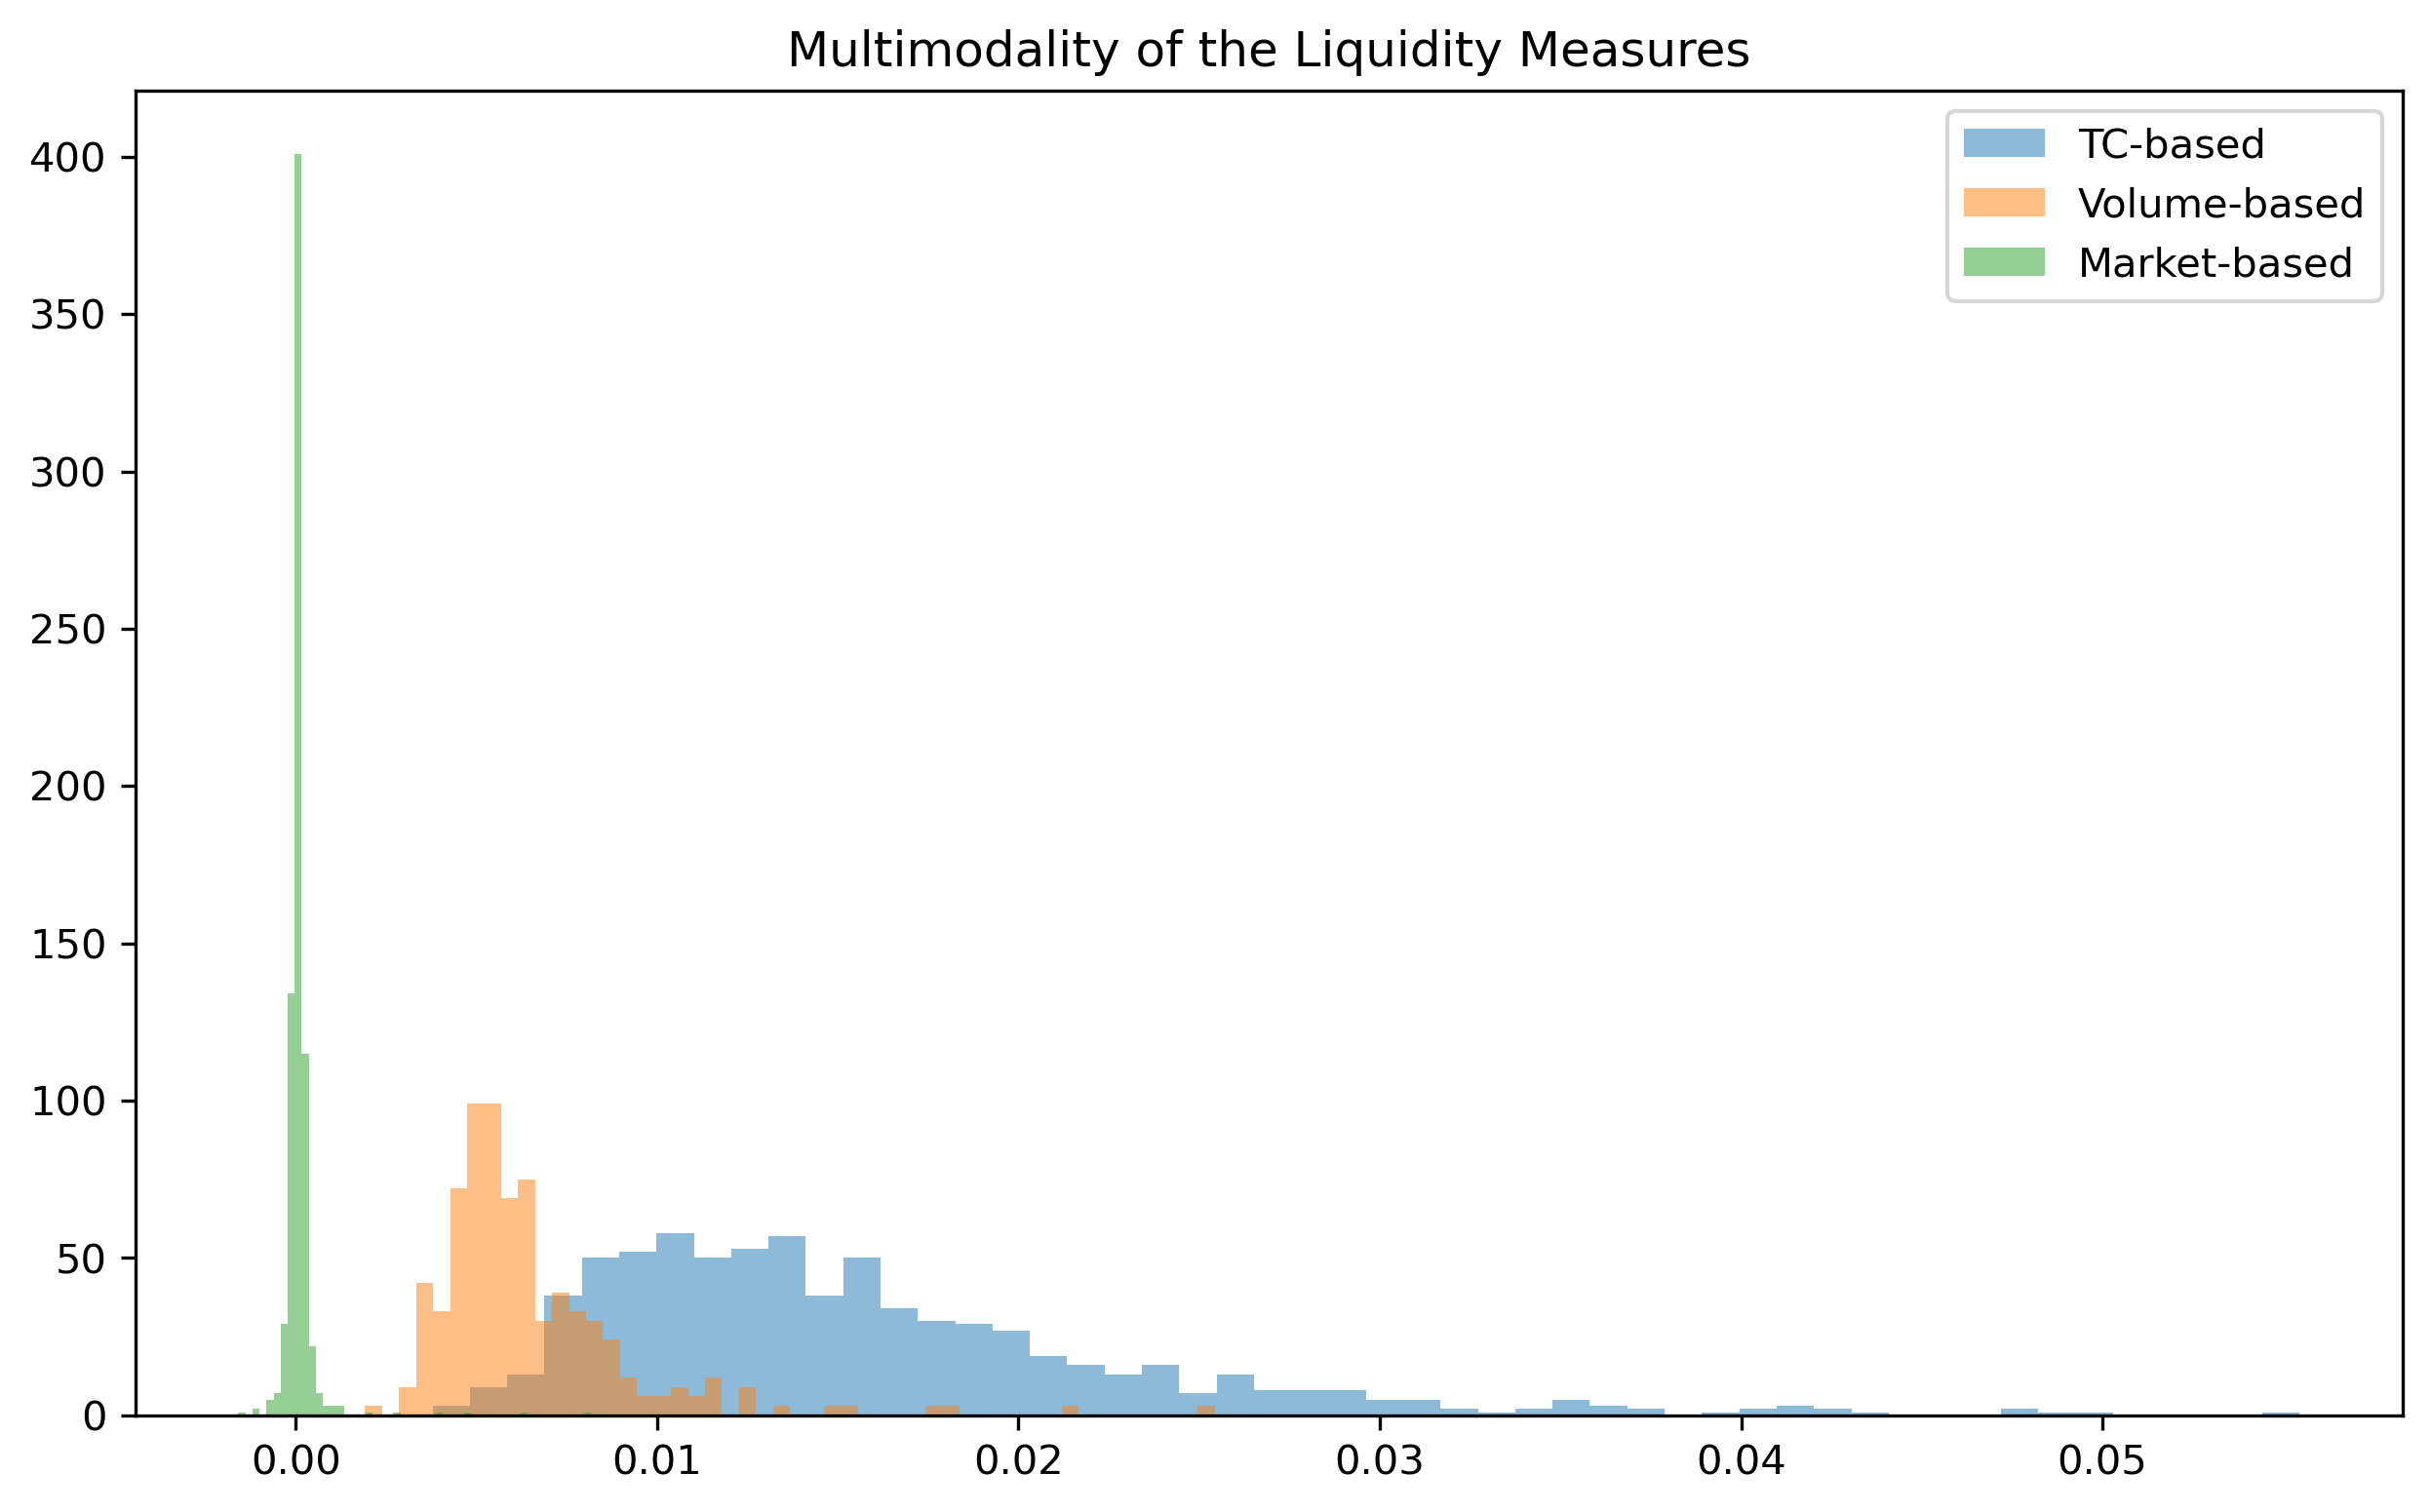

In [32]:
kwargs = dict(alpha=0.5, bins=50,  stacked=True)
plt.hist(liq_measures_all.loc[:, 'percent_quoted_ba'],
         **kwargs, label='TC-based')
plt.hist(liq_measures_all.loc[:, 'turnover_ratio'],
         **kwargs, label='Volume-based')
plt.hist(liq_measures_all.loc[:, 'market_impact'],
         **kwargs, label='Market-based')
plt.title('Multimodality of the Liquidity Measures')
plt.legend()
plt.show()

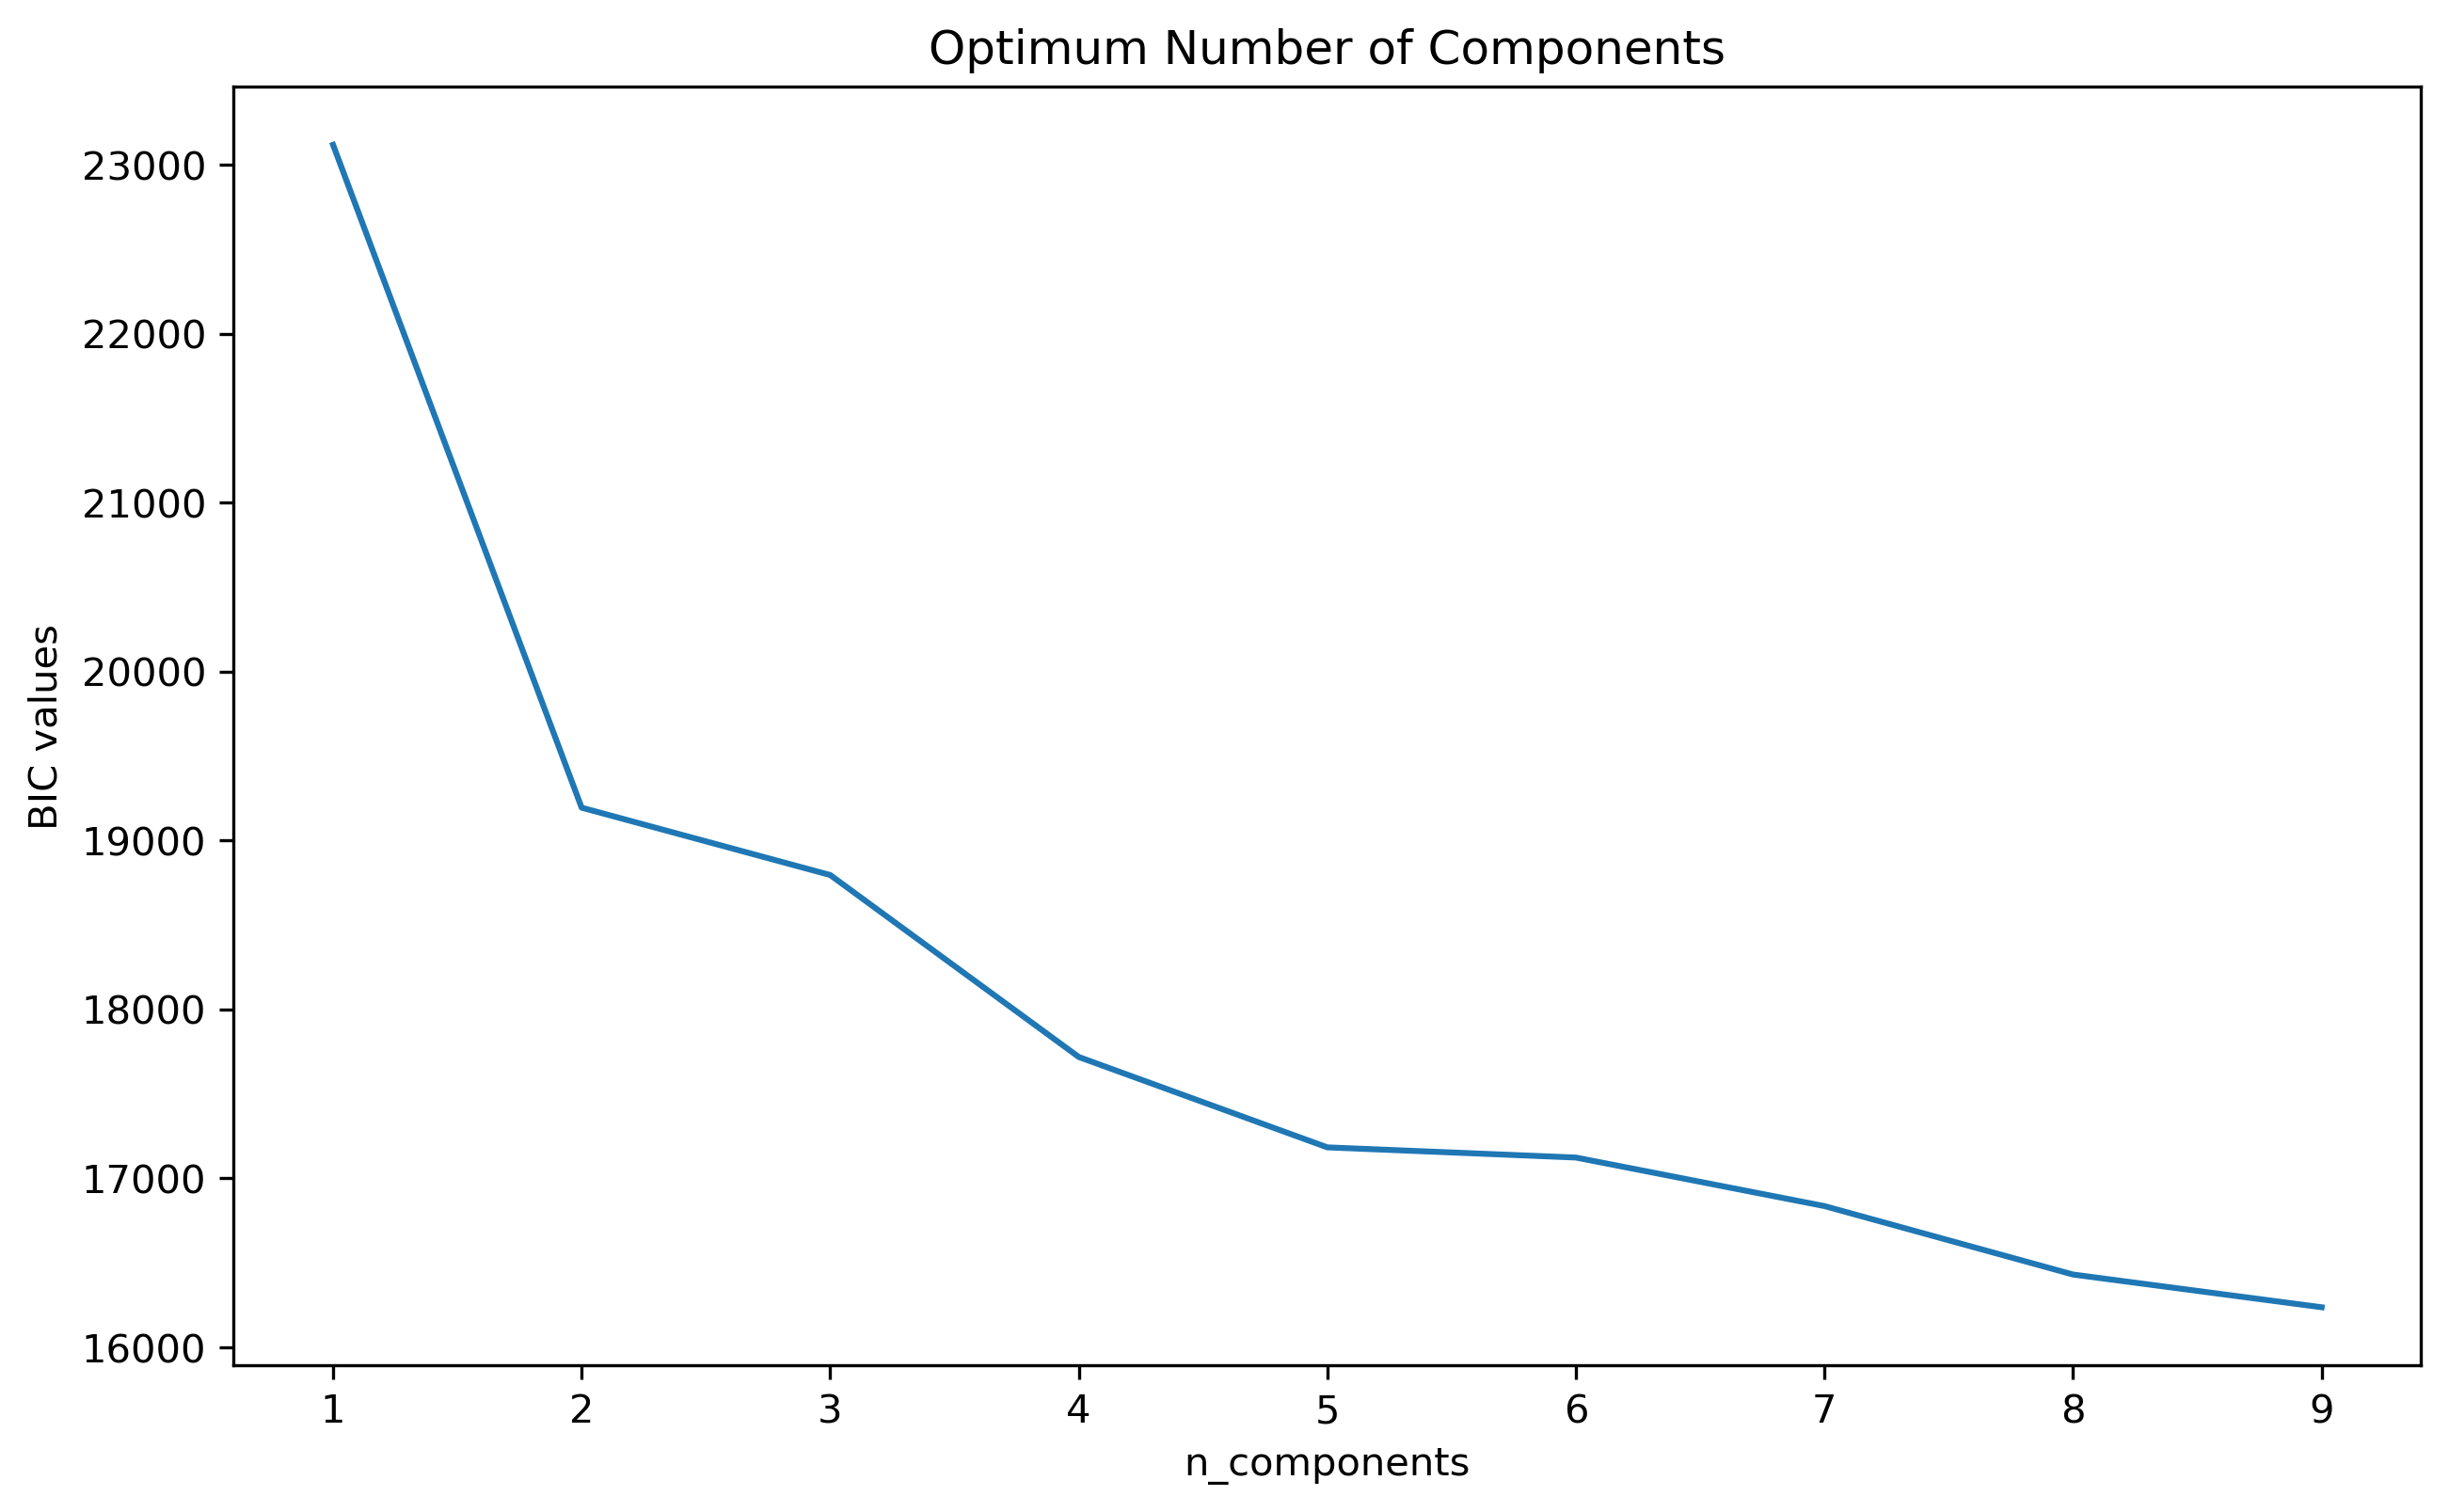

In [33]:
n_components = np.arange(1, 10)
clusters = [GaussianMixture(n, covariance_type='spherical',
                            random_state=0).fit(scaled_liq)
          for n in n_components]
plt.plot(n_components, [m.bic(scaled_liq) for m in clusters])
plt.title('Optimum Number of Components')
plt.xlabel('n_components')
plt.ylabel('BIC values')
plt.show()

In [34]:
def cluster_state(data, nstates):
    gmm = GaussianMixture(n_components=nstates,
                          covariance_type='spherical',
                          init_params='kmeans')
    gmm_fit = gmm.fit(scaled_liq)
    labels = gmm_fit.predict(scaled_liq)
    state_probs = gmm.predict_proba(scaled_liq)
    state_probs_df = pd.DataFrame(state_probs, 
                                  columns=['state-1','state-2','state-3'])
    state_prob_means = [state_probs_df.iloc[:, i].mean() 
                        for i in range(len(state_probs_df.columns))]
    if np.max(state_prob_means) == state_prob_means[0]:
        print('State-1 is likely to occur with a probability of {:4f}'
              .format(state_prob_means[0]))
    elif np.max(state_prob_means) == state_prob_means[1]:
        print('State-2 is likely to occur with a probability of {:4f}'
              .format(state_prob_means[1]))
    else:
        print('State-3 is likely to occur with a probability of {:4f}'
              .format(state_prob_means[2]))
    return state_probs

In [35]:
state_probs = cluster_state(scaled_liq, 3)
print(f'State probabilities are {state_probs.mean(axis=0)}')

State-3 is likely to occur with a probability of 0.544785
State probabilities are [0.06414084 0.39107443 0.54478473]


In [36]:
from sklearn.decomposition import PCA

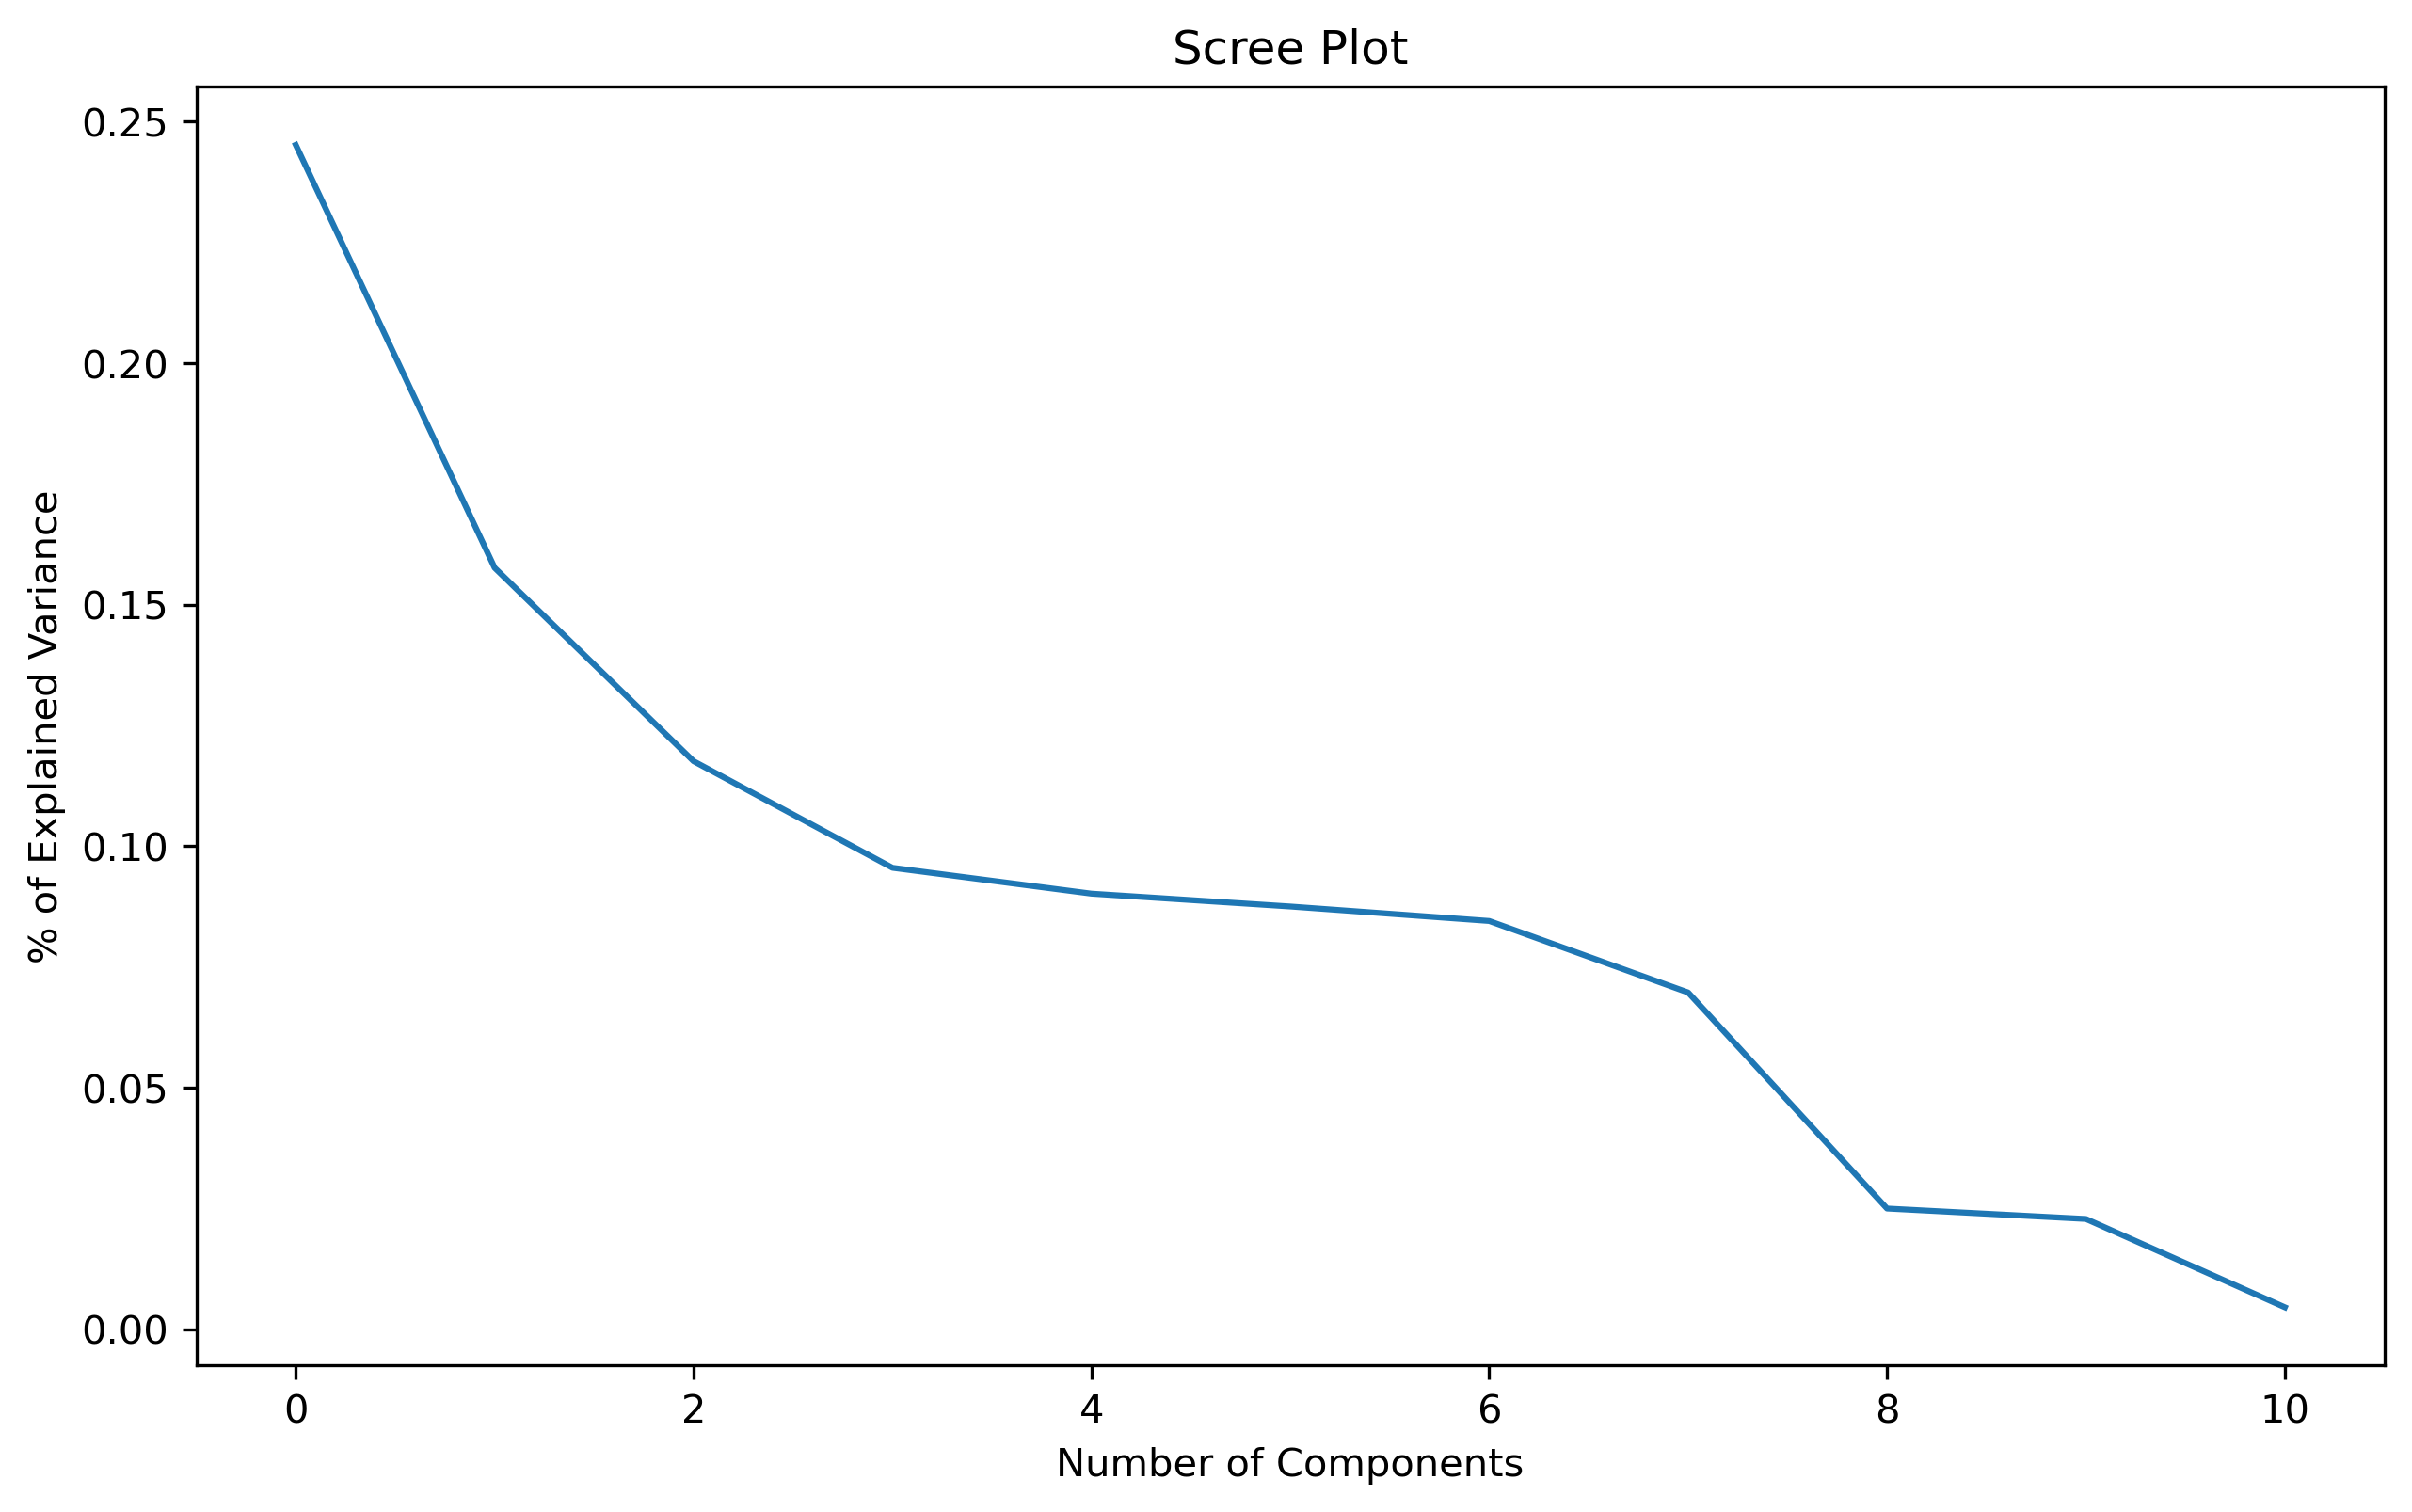

In [37]:
pca = PCA(n_components=11)
components = pca.fit_transform(scaled_liq)
plt.plot(pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('% of Explained Variance')
plt.show()

In [38]:
def gmm_pca(data, nstate):
    pca = PCA(n_components=3)
    components = pca.fit_transform(data)
    mxtd = GaussianMixture(n_components=nstate,
                           covariance_type='spherical')
    gmm = mxtd.fit(components)
    labels = gmm.predict(components)
    state_probs = gmm.predict_proba(components)
    return state_probs,pca

In [39]:
state_probs, pca = gmm_pca(scaled_liq, 3)
print(f'State probabilities are {state_probs.mean(axis=0)}')

State probabilities are [0.05226668 0.65391502 0.2938183 ]


In [40]:
def wpc():
    state_probs_df = pd.DataFrame(state_probs,
                                  columns=['state-1', 'state-2',
                                           'state-3'])
    state_prob_means = [state_probs_df.iloc[:, i].mean() 
                        for i in range(len(state_probs_df.columns))]
    if np.max(state_prob_means) == state_prob_means[0]:
        print('State-1 is likely to occur with a probability of {:4f}'
              .format(state_prob_means[0]))
    elif np.max(state_prob_means) == state_prob_means[1]:
        print('State-2 is likely to occur with a probability of {:4f}'
              .format(state_prob_means[1]))
    else:
        print('State-3 is likely to occur with a probability of {:4f}'
              .format(state_prob_means[2]))
wpc()

State-2 is likely to occur with a probability of 0.653915


In [41]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, 
                              columns=['PC1', 'PC2', 'PC3'],
                              index=liq_measures_all.columns)
loading_matrix

,PC1,PC2,PC3
liq_ratio,0.116701,-0.115791,-0.196355
Lhh,-0.211827,0.882007,-0.125890
turnover_ratio,0.601041,-0.006381,0.016222
percent_quoted_ba,0.713239,0.140103,0.551385
percent_effective_ba,0.641527,0.154973,0.526933
roll,-0.070192,0.886080,-0.093126
CS_spread,0.013373,-0.299229,-0.092705
amihud,0.849614,-0.020623,-0.488324
florackis,0.710818,0.081948,-0.589693
cet,-0.035736,0.101575,0.001595


## GMCM

In [53]:
#pip install copulae

In [54]:
#pip install numpy==1.20.0

In [51]:
#from copulae.mixtures.gmc.gmc import GaussianMixtureCopula

In [55]:
#from copulae import GaussianCopula

In [ ]:
_, dim = scaled_liq.shape
gmcm = GaussianCopula(n_clusters=3, ndim=dim)

In [ ]:
gmcm_fit = gmcm.fit(scaled_liq, method='kmeans',
                    criteria='GMCM', eps=0.0001)
state_prob = gmcm_fit.params.prob
print(f'The state {np.argmax(state_prob) + 1} is likely to occur')
print(f'State probabilities based on GMCM are {state_prob}')